In [ ]:
import ctypes

ctypes.windll.kernel32.SetThreadExecutionState(
    0x80000000 | 0x00000001  # ES_CONTINUOUS | ES_SYSTEM_REQUIRED
)

-2147483648

In [5]:
import ctypes
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)

-2147483647

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
from scipy.integrate import quad

# ========== Load Pantheon+ SN Data ==========
sn_data = pd.read_csv("DISTANCES_AND_COVAR\Pantheon+SH0ES.dat", delim_whitespace=True)

ww = (sn_data['zHD']>0.01) | (np.array(sn_data['IS_CALIBRATOR'],dtype=bool))
origlen = len(sn_data)

z_cmb = sn_data["zHD"][ww].values
z_hel = sn_data["zHEL"][ww].values
# mu_obs = sn_data["MU_SH0ES"].values
mu_obs = sn_data["m_b_corr"][ww].values
ceph_dist = sn_data["CEPH_DIST"][ww].values
is_cal = sn_data["IS_CALIBRATOR"][ww].values.astype(bool) 

with open("DISTANCES_AND_COVAR\Pantheon+SH0ES_STAT+SYS.cov", "r") as f:
        line = f.readline()
        n = int(len(z_cmb))
        C = np.zeros((n,n))
        ii = -1
        jj = -1
        for i in range(origlen):
            jj = -1
            if ww[i]:
                ii += 1
            for j in range(origlen):
                if ww[j]:
                    jj += 1
                val = float(f.readline())
                if ww[i]:
                    if ww[j]:
                        C[ii,jj] = val

Cinv = np.linalg.inv(C)
#     N = int(f.readline())
#     cov_vals = np.fromiter((float(x.strip()) for x in f), dtype=float)
# C_SN = cov_vals.reshape(N, N)
mu_th = z_cmb*np.nan
mu_th[np.array(is_cal,dtype='bool')] = ceph_dist[np.array(is_cal,dtype='bool')]

zcmb = z_cmb[~np.array(is_cal,dtype='bool')]
zhel = z_hel[~np.array(is_cal,dtype='bool')]

C:\Users\GTS\AppData\Local\Temp\ipykernel_50992\513265352.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sn_data = pd.read_csv("DISTANCES_AND_COVAR\Pantheon+SH0ES.dat", delim_whitespace=True)


In [130]:
print( ceph_dist[is_cal])

[29.177  29.177  30.8433 30.8433 30.8338 30.5454 30.5454 30.5454 30.5454
 31.2859 31.6336 31.7216 31.8115 31.2859 31.4903 31.4903 31.6272 31.6272
 31.9348 31.9348 31.3773 31.3773 31.4489 31.4489 31.6025 31.6025 32.1194
 32.0504 32.0504 32.0504 31.7708 31.7708 31.7708 31.7708 32.3302 32.3302
 32.4626 32.2221 32.2221 32.2221 32.3624 32.3624 32.3624 32.5404 32.5404
 32.8472 32.8472 32.8472 32.4996 32.4996 32.5621 32.5621 32.5621 32.6114
 32.8293 32.8026 32.5982 32.9183 32.9183 32.9183 33.1156 33.1156 33.1156
 33.1156 33.0928 33.0928 33.0928 33.245  33.0131 33.1859 33.1859 33.0131
 33.0131 33.7082 33.7082 34.526  34.526 ]


In [ ]:
import numpy as np
from scipy.integrate import quad
import pandas as pd


c = 299792.458  # km/s

def E_z(z, Om, w0, wa):
    # Ok = 1.0 - Om - OL
    OL = 1.0 - Om
    return np.sqrt(Om * (1+z)**3 + OL* (1+z)**(3*(1+w0+wa)) * np.exp(-3*wa*z/(1+z)))


def d_C(z, Om, w0, wa, H0):
    # Ok = 1.0 - Om - OL
    chi = np.array([
        quad(lambda zz: 1.0 / E_z(zz, Om, w0, wa), 0, zi, epsrel=1e-6, limit=50)[0] for zi in z
    ])
    D_C = (c / H0) * chi
    # return D_C / (1 + z) 
    return D_C 


def mu_model(Om, w0, wa, H0, M):

    DC = d_C(zcmb, Om, w0, wa, H0)
    # DL = (1 + zcmb_nc) * (1 + zhel_nc) * DA
    DL = (1 + zhel) * DC 
    mu_nc = 5 * np.log10(DL) + 25
    mu_th[~np.array(is_cal,dtype='bool')] = mu_nc
    return mu_th + M

def chi2_total(theta):
    Om, w0, wa, H0, M = theta

    mu_th = mu_model(Om, w0, wa, H0, M)
    delta = mu_obs - mu_th

    return delta.T @ Cinv @ delta



In [6]:
theta0 = [0.33, -1.1, -0.5, 72.0, -19]
bounds = [(0.1, 0.9), (-2.0, 0.5), (-4.0, 4.0), (55, 91), (-20, -18)]
result = minimize(chi2_total, theta0, method='L-BFGS-B', bounds=bounds)
Om_fit, w0_fit, wa_fit, H0_fit, M_fit = result.x
print(f"Best-fit: Omega_m = {Om_fit:.3f}, w0 = {w0_fit:.2f}, wa = {wa_fit:.2f}, H0 = {H0_fit:.2f}, M = {M_fit:.2f}")

Best-fit: Omega_m = 0.312, w0 = -0.92, wa = -0.17, H0 = 73.42, M = -19.24


In [ ]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

# === log-prior ===
def log_prior(theta):
    Om, w0, wa, H0, M = theta
    if not (0.1 <= Om <= 0.9): return -np.inf
    if not (-2 <= w0 <= 0.5): return -np.inf
    if not (-4 <= wa <= 4): return -np.inf
    if not (55 <= H0 <= 91): return -np.inf
    if not (-20 <= M <= -18): return -np.inf
    return 0.0

# === log-likelihood ===
def log_likelihood(theta):
    try:
        return -0.5 * chi2_total(theta)
    except:
        return -np.inf

# === log-posterior ===
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    return lp + log_likelihood(theta)


ndim = 5
nwalkers = 32
theta_init = np.array([0.33, -1.1, -0.5, 72.0, -19.0])
p0 = theta_init + 1e-4 * np.random.randn(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 3000, progress=True)


100%|██████████| 3000/3000 [1:36:57<00:00,  1.94s/it]


State([[  0.18181259  -0.65247653  -0.29170591  71.39554804 -19.29455616]
 [  0.32127472  -0.76601096  -1.42493028  72.92214208 -19.24991415]
 [  0.44876479  -1.33345564  -0.85015274  74.16532165 -19.23385431]
 [  0.11115811  -0.73650915   0.76839307  73.517207   -19.24042941]
 [  0.4324358   -0.87646492  -3.19737398  73.89010955 -19.21470603]
 [  0.36478567  -0.89676177  -0.91213591  74.16303671 -19.20723399]
 [  0.27291214  -0.92604186   0.35250031  75.26750802 -19.19336594]
 [  0.46329531  -0.91507087  -3.91110337  72.6398724  -19.25402242]
 [  0.29130711  -1.01120294   0.72047916  72.60708497 -19.26826848]
 [  0.33402116  -0.93595982   0.18405703  73.73934096 -19.22552625]
 [  0.23320006  -0.84371035   0.40015034  73.11572452 -19.24975928]
 [  0.34879448  -0.99449051  -0.65771773  72.98831278 -19.25744566]
 [  0.35995851  -0.81946567  -1.18978038  73.29667744 -19.22680193]
 [  0.24924645  -0.82877239   0.35817883  73.14095693 -19.25007228]
 [  0.39373088  -0.98607566  -1.70806156  

In [7]:
tau = sampler.get_autocorr_time()
recommended_thin = int(np.mean(tau))
print(f"Recommended thinning: {recommended_thin}")

Recommended thinning: 43


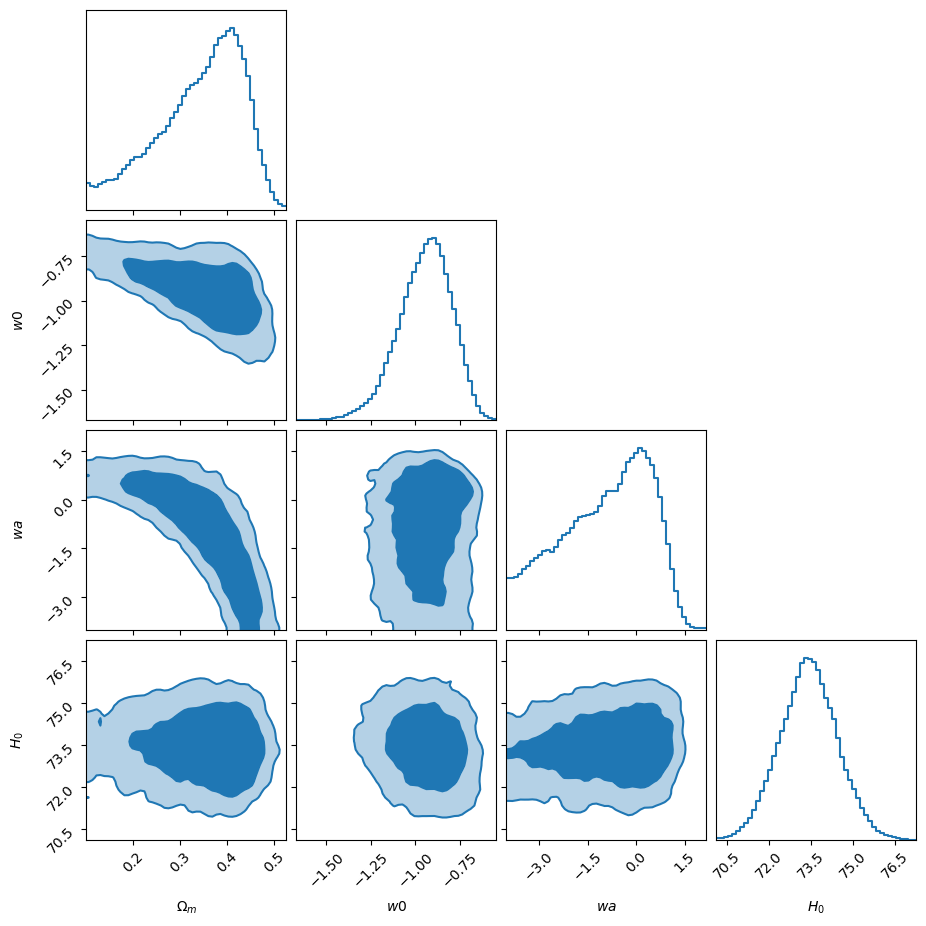

$\Omega_m$ = 0.36 (+0.07/-0.11)
$w0$ = -0.93 (+0.13/-0.16)
$wa$ = -0.76 (+1.22/-1.80)
$H_0$ = 73.44 (+0.99/-1.02)
$M$ = -19.24 (+0.03/-0.03)
$\Omega_\Lambda$ = 0.64 (+0.11/-0.07)


In [ ]:
samples = sampler.get_chain(discard=500, thin=10, flat=True)
Om = samples[:, 0]
w0 = samples[:, 1]
wa = samples[:, 2]
H0 = samples[:, 3]
M = samples[:, 4]
Ol = 1.0 - Om
samples = np.array([Om, w0, wa, H0, M, Ol]).T

labels = [r"$\Omega_m$", r"$w0$", r"$wa$", r"$H_0$", r"$M$", r"$\Omega_\Lambda$"]
corner.corner(samples[:,[0,1,2,3]], labels=labels[:4],smooth=1.2, smooth1d=1, fill_contours=True, bins=50, plot_datapoints=False, plot_density=True, levels=(0.68, 0.95), color='C0', alpha=0.5)
plt.savefig("corner_plot_Flatw0waCDM.png", dpi=500)
plt.show()


for i, label in enumerate(labels):
    q16, q50, q84 = np.percentile(samples[:, i], [16, 50, 84])
    print(f"{label} = {q50:.2f} (+{q84 - q50:.2f}/-{q50 - q16:.2f})")

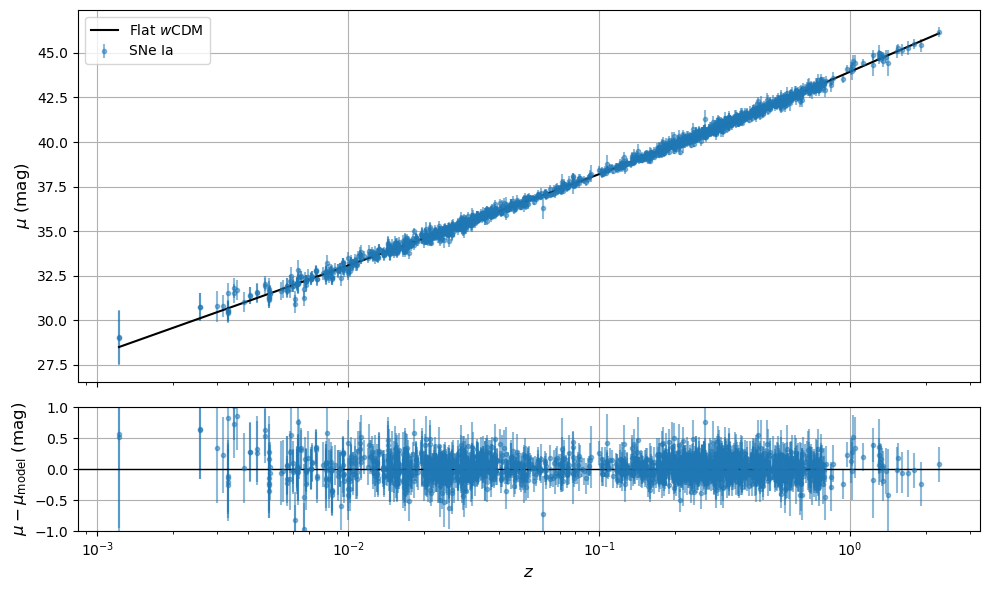

In [ ]:
c = 299792.458  # km/s
def mu_theory(z, Om, w0, wa, H0, M):

    DC = d_C(z, Om, w0, wa, H0)
    # DL = (1 + zcmb_nc) * (1 + zhel_nc) * DA
    DL = (1 + z_h) * DC 
    mu_th = 5 * np.log10(DL) + 25
    return mu_th 

Om_fit, w0_fit, wa_fit, H0_fit, M_fit = [np.percentile(samples[:,i], [50]) for i in range(5)]
Om_fit = Om_fit[0]
w0_fit = w0_fit[0]
wa_fit = wa_fit[0]
H0_fit = H0_fit[0]
M_fit = M_fit[0]
z = sn_data["zHD"]   
z_h = sn_data["zHEL"]            
muobs = sn_data["MU_SH0ES"]             
muerr = sn_data["MU_SH0ES_ERR_DIAG"]            
mumodel = mu_theory(z, Om_fit, w0_fit, wa_fit, H0_fit, M_fit)          


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, height_ratios=[3, 1])
fig.subplots_adjust(hspace=0)


ax1.errorbar(z, muobs, yerr=muerr, fmt='.', alpha=0.5, label='SNe Ia')
ax1.plot(np.sort(z), mumodel[np.argsort(z)], 'k-', label='Flat $w$CDM')

ax1.set_ylabel(r'$\mu$ (mag)', fontsize=12)
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True)

residual = muobs - mumodel
ax2.errorbar(z, residual, yerr=muerr, fmt='.', alpha=0.5)
ax2.axhline(0, color='k', lw=1)
ax2.set_xlabel(r'$z$', fontsize=12)
ax2.set_ylabel(r'$\mu - \mu_{\mathrm{model}}$ (mag)', fontsize=12)
ax2.set_xscale('log')
ax2.set_ylim(-1, 1)
ax2.grid(True)

plt.tight_layout()
plt.show()